In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astropy.modeling import models, fitting
from astroquery.nist import Nist # atomic lines
from astroquery.linelists.cdms import CDMS # molecular lines?

from scipy.integrate import trapz
from scipy.optimize import curve_fit
from scipy.signal import medfilt

from astropy.io import ascii
from astropy.io import fits


%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [3]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + b

# Reduced and order-merged data filepath 
# Desktop path
# data_path = "A:\\Documents\\Grad_School\\IGRINS-Spectra\\IGRINS_Merged"
# C:\Users\Savio\Documents\IGRINS-Spectra\standards_velocity_shifts.ipynb
# Laptop Path
# data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"
# File path for figures to live in
# Desktop path
# fig_path = "A:\\Documents\\Grad_School\\IGRINS-Spectra\\IGRINS_figs\\standards_spectra"

# Laptop Path
# fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"


# Create the folder if it doesn't exist
# if not os.path.exists(fig_path):
#     os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table.txt') # csv of standards with file and Spectral Type, c/v TBA
standard_list = standard_table['Source']

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

In [22]:
# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)
# Initialize flux_stack with NaN values

wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(standard_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size = 51)
    norm_flux = flux/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.48
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    mask = snr_cut & flux_cut & wavelen_cut
    wavelen = wavelen[mask]
    norm_flux = norm_flux[mask]

    # Remove NaNs and infs from wavelen and norm_flux arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isinf(wavelen) & ~np.isnan(norm_flux) & ~np.isinf(norm_flux)
    wavelen = wavelen[valid_indices]
    norm_flux = norm_flux[valid_indices]

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    flux_stack[:len(norm_flux), i] = norm_flux  # Normalized flux arrays for each standard

# Determine the maximum length of flux arrays for the protostars
max_flux_length = max(len(fits.getdata(file)[1]) for file in hops_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in hops_list)
# Initialize flux_stack with NaN values

hops_wavelen_stack = np.full((max_wavelen_length, len(hops_list)), np.nan)
hops_flux_stack = np.full((max_flux_length, len(hops_list)), np.nan)
hops_snr_stack = np.full((max_snr_length, len(hops_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(hops_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size=51)
    norm_flux = flux/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.48
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    wavelen = wavelen[snr_cut & flux_cut & wavelen_cut]
    norm_flux = norm_flux[snr_cut & flux_cut  & wavelen_cut]

    hops_wavelen_stack[:len(wavelen),i] = wavelen # wavelength arrays for each standard
    hops_flux_stack[:len(norm_flux),i] = norm_flux # normalized flux arrays for each standard 

# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.0*u.um,2.48*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')
igrins_wav_cut = (lines_table['Observed'] > 1.92) & (lines_table['Observed'] < 2.48)

lines_table = lines_table[igrins_wav_cut]
# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

# lines_table[fe1_mask] # check where some lines are

C:\Users\Savio\AppData\Local\Temp\ipykernel_2084\1805097130.py:17: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux
C:\Users\Savio\AppData\Local\Temp\ipykernel_2084\1805097130.py:61: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


In [23]:
len(wavelen_stack[:,0]), len(flux_stack[:,0])

(44642, 44642)

In [24]:
# Initialize an empty list to store vel_over_c values for each source
vel_over_c_list = []
wavelen_shift_list = []

# Loop through each source in standard_table
for standard in range(len(standard_table)):
    # Calculate the minimum flux within the specified wavelength range for the current source
    min_flux = np.nanmin(flux_stack[:, standard][(wavelen_stack[:, standard] > 2.206) & (wavelen_stack[:, standard] < 2.207)])
    
    # Find the index where the minimum flux occurs for the current source
    min_flux_index = np.where(flux_stack[:, standard] == min_flux)[0][0]  # Assuming min_flux_index is a scalar
    
    # Get the wavelength corresponding to the minimum flux for the current source
    min_flux_wavelength = wavelen_stack[min_flux_index, standard]
    
    # Calculate the wavelength shift for the current source
    wavelen_shift = min_flux_wavelength - lines_table[na1_mask]['Observed'][0]
    
    # Calculate vel_over_c for the current source
    vel_over_c = wavelen_shift / lines_table[na1_mask]['Observed'][0]
    
    # Append vel_over_c  and wavelen_shift to the list
    wavelen_shift_list.append(wavelen_shift)
    vel_over_c_list.append(vel_over_c)

# Convert the list to a NumPy array if needed
vel_over_c_array = np.array(vel_over_c_list)
wavelen_shift_array = np.array(wavelen_shift_list)
# vel_over_c_array, wavelen_shift_array

(array([1.07887641e-04, 1.07887641e-04, 4.44532101e-05, 9.88101416e-05,
        1.57705823e-04, 3.99144604e-05, 1.39550824e-04, 1.26042640e-04,
        4.44532101e-05, 9.42713919e-05, 3.99144604e-05, 3.99144604e-05,
        3.99144604e-05, 1.30581390e-04, 1.16965141e-04, 1.39550824e-04,
        3.08369609e-05]),
 array([2.38026245e-04, 2.38026245e-04, 9.80745392e-05, 2.17999084e-04,
        3.47937210e-04, 8.80609589e-05, 3.07882889e-04, 2.78080566e-04,
        9.80745392e-05, 2.07985504e-04, 8.80609589e-05, 8.80609589e-05,
        8.80609589e-05, 2.88094147e-04, 2.58053406e-04, 3.07882889e-04,
        6.80337982e-05]))

In [25]:
# delta lambda and v/c only based on one Na I line...
standard_table[r'v/c'] = vel_over_c_array
standard_table['Wavelength_Shift'] = wavelen_shift_array

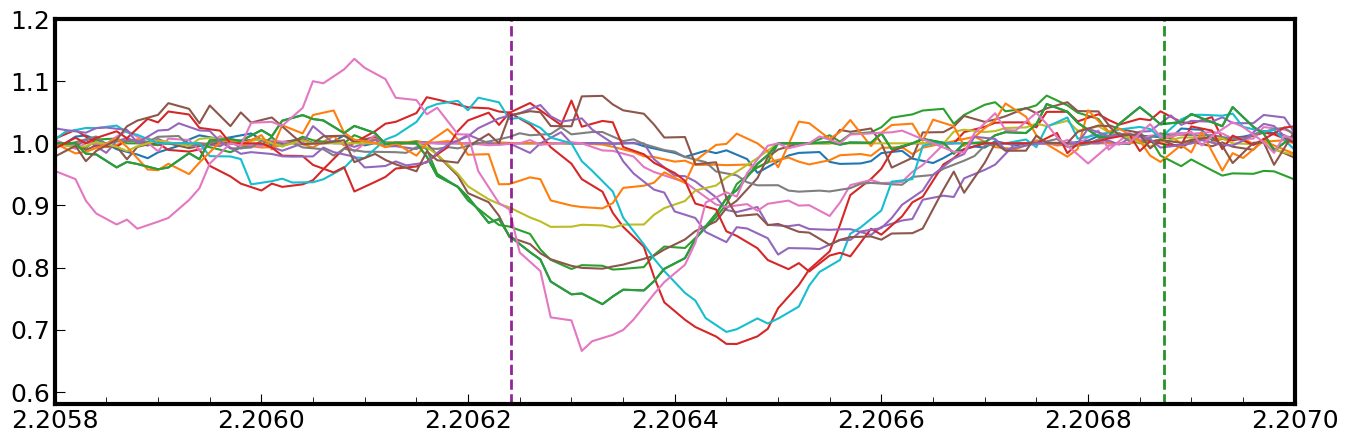

In [32]:
wave_min = 2.206 # just checking the Na I doublet
wave_max = 2.207

fig, ax = plt.subplots(figsize=(16,5))
# plt.plot(wavelen_stack[:,:],flux_stack[:,:]) # just to show
for i in range(len(standard_list)):
    plt.plot(wavelen_stack[:,i],flux_stack[:,i],ls='-') # Shifted

line_mask = (lines_table['Observed'] >= wave_min) & (lines_table['Observed'] <= wave_max) # bitwise conditional for NIST lines
label_added = {} # Just to keep track in the loop below

for spectrum, color in zip(mask_list,color_list):
        for i in range(len(lines_table[line_mask & spectrum])):
            spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
            if spec_label not in label_added:  # Check if label has been added to the legend
                plt.axvline(lines_table[line_mask & spectrum]['Observed'][0],
                            ymin=0, ymax=0,
                              ls='--', c=color, label=spec_label)

                label_added[spec_label] = True  # Mark label as added

            plt.axvline(lines_table[line_mask & spectrum]['Observed'][i],
                        ls='--',lw=2,alpha=0.85, c=color) # ymin= 0.95 - 0.05 * list(label_added.keys()).index(spec_label), ymax = 1 - 0.05 * list(label_added.keys()).index(spec_label)



plt.xlim(wave_min-20*spec_res,wave_max)
plt.ylim(0.58,1.2)

# plt.legend()
plt.show()

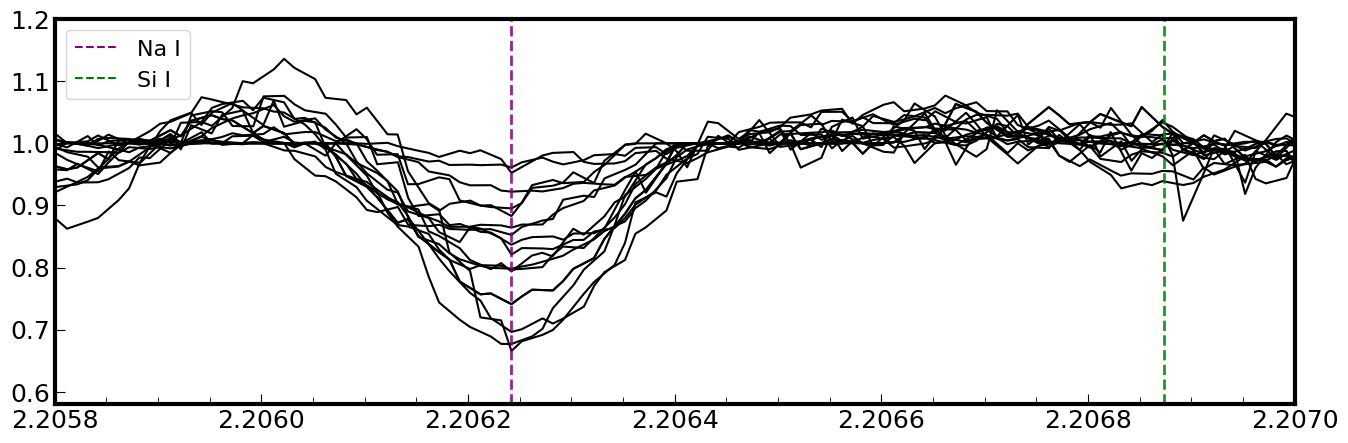

In [38]:
# wave_min = 2.206 # just checking the Na I doublet
# wave_max = 2.21
source = 3

fig,ax = plt.subplots(figsize=(16,5))
# plt.plot(wavelen_stack[:,:],flux_stack[:,:]) # just to show
for i in range(len(standard_list)):
    plt.plot(wavelen_stack[:,i]-standard_table['Wavelength_Shift'][i],flux_stack[:,i],ls='-',c='k') # Shifted

line_mask = (lines_table['Observed'] >= wave_min) & (lines_table['Observed'] <= wave_max) # bitwise conditional for NIST lines
label_added = {} # Just to keep track in the loop below

for spectrum, color in zip(mask_list,color_list):
        for i in range(len(lines_table[line_mask & spectrum])):
            spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
            if spec_label not in label_added:  # Check if label has been added to the legend
                plt.axvline(lines_table[line_mask & spectrum]['Observed'][0],
                            ymin=0, ymax=0,
                              ls='--', c=color, label=spec_label)

                label_added[spec_label] = True  # Mark label as added

            plt.axvline(lines_table[line_mask & spectrum]['Observed'][i],
                        ls='--',lw=2,alpha=0.85, c=color) # ymin= 0.95 - 0.05 * list(label_added.keys()).index(spec_label), ymax = 1 - 0.05 * list(label_added.keys()).index(spec_label)

plt.xlim(wave_min-20*spec_res,wave_max)
plt.ylim(0.58,1.2)

plt.legend()
plt.show()

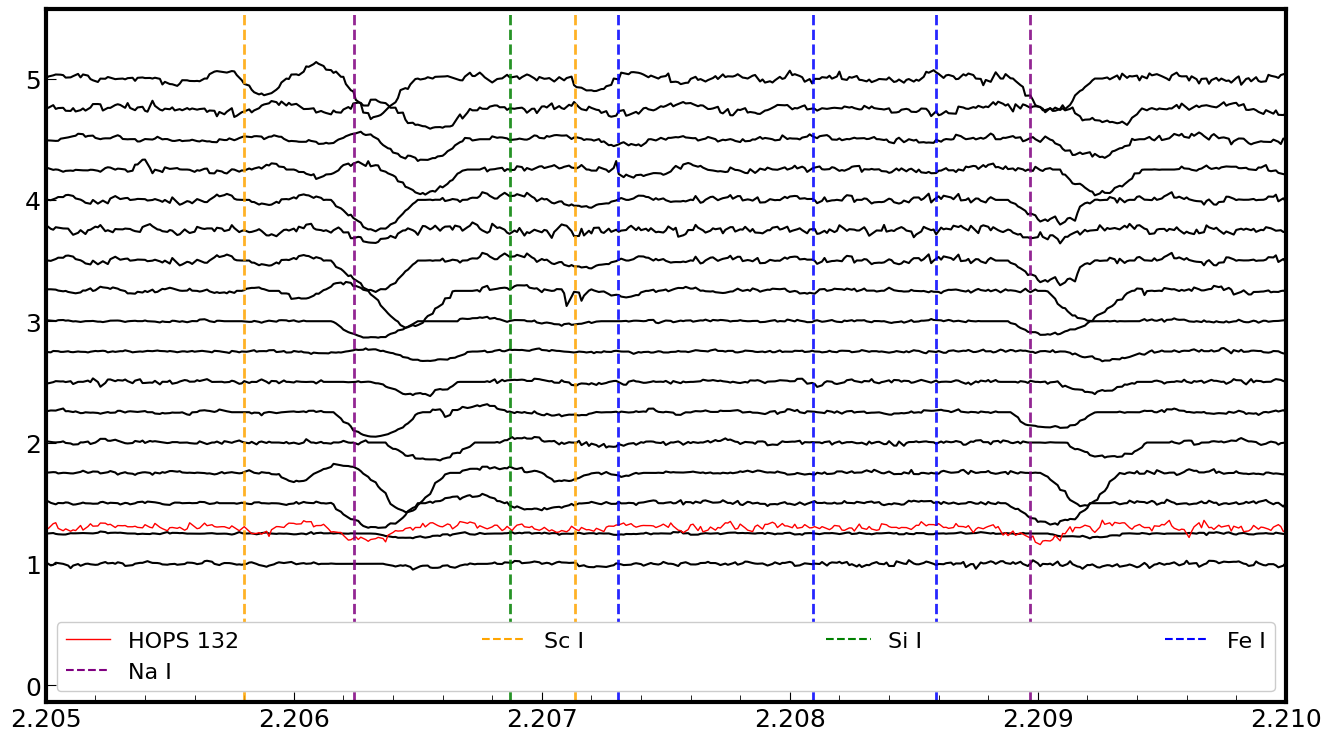

In [29]:
fig = plt.subplots(figsize=(16,9))
flux_const = np.linspace(0,4,len(standard_list))

wave_min = 2.205
wave_max = 2.210

for standard in range(len(standard_list)):
    plt.plot(wavelen_stack[:,standard],flux_stack[:,standard]+flux_const[standard],c='black')

plt.plot(hops_wavelen_stack[:,0],hops_flux_stack[:,0]+0.3,c='red',lw=1,label='HOPS 132')
    
line_mask = (lines_table['Observed'] >= wave_min) & (lines_table['Observed'] <= wave_max) # bitwise conditional for NIST lines
label_added = {} # Just to keep track in the loop below

for spectrum, color in zip(mask_list,color_list):
        for i in range(len(lines_table[line_mask & spectrum])):
            spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
            if spec_label not in label_added:  # Check if label has been added to the legend
                plt.axvline(lines_table[line_mask & spectrum]['Observed'][0],
                            ymin=0, ymax=0,
                              ls='--', c=color, label=spec_label)

                label_added[spec_label] = True  # Mark label as added

            plt.axvline(lines_table[line_mask & spectrum]['Observed'][i],
                        ls='--',lw=2,alpha=0.85, c=color) # ymin= 0.95 - 0.05 * list(label_added.keys()).index(spec_label), ymax = 1 - 0.05 * list(label_added.keys()).index(spec_label)

plt.xlim(wave_min,wave_max)
# plt.ylim(0.5,2.25)
plt.legend(framealpha=1,ncol=4,mode='expand',facecolor='white',labelcolor='black',loc='lower center')
plt.show()